# Dataloaders

In [74]:
import os
import pandas as pd
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

### One description per image

In [58]:
df = pd.read_csv('flickr/captions.txt')
df[:6]

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting


In [59]:
df.drop_duplicates(subset=['image'], inplace=True)

In [60]:
df[:6]

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
10,1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front o...
15,1003163366_44323f5815.jpg,A man lays on a bench while his dog sits by him .
20,1007129816_e794419615.jpg,A man in an orange hat starring at something .
25,1007320043_627395c3d8.jpg,A child playing on a rope net .


In [61]:
df.to_csv('flickr/one_desc.txt', index=0)

In [62]:
df = pd.read_csv('flickr/one_desc.txt')

In [63]:
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
2,1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front o...
3,1003163366_44323f5815.jpg,A man lays on a bench while his dog sits by him .
4,1007129816_e794419615.jpg,A man in an orange hat starring at something .


## Converting text to numerical values
1. Vocabulary mapping each word to an index
2. Pytorch dataset
3. padding sequnences to the same length

In [64]:
# loading spacy tokenizer
spacy_en = spacy.load("en")

In [65]:
itos = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"}
stoi = {"<PAD>":0, "<SOS>":1, "<EOS>":2, "<UNK>":3}
class Vocabulary:
    def __init__(self, freq_threshold):

        self.freq_threshold = freq_threshold
        
    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_en.tokenizer(text)]
    
    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1
                    
                if frequencies[word] == self.freq_threshold:
                    stoi[word] = idx
                    itos[idx] = word
                    idx += 1
                    
    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)
        
        return [
            stoi[token] if token in stoi else stoi["<UNK>"]
            for token in tokenized_text
        ]

In [69]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(root_dir +'/'+ captions_file)
        self.transform = transform
        
        # get img and caption columns
        self.imgs = self.df['image']
        self.captions = self.df['caption']
        
        # initialize vacab and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir,"images", img_id)).convert("RGB")
        
        if self.transform is not None:
            img = self.transform(img)
            
        numericalized_caption = [stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(stoi["<EOS>"])
        
        return img, torch.tensor(numericalized_caption)

In [70]:
df = pd.read_csv('flickr/one_desc.txt')
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
2,1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front o...
3,1003163366_44323f5815.jpg,A man lays on a bench while his dog sits by him .
4,1007129816_e794419615.jpg,A man in an orange hat starring at something .


In [71]:
ds = FlickrDataset('flickr/', 'one_desc.txt')

In [72]:
for i in range(5):
    print(ds[i][0].size, ds[i][1].shape)

(375, 500) torch.Size([20])
(500, 375) torch.Size([11])
(500, 400) torch.Size([22])
(500, 410) torch.Size([15])
(500, 461) torch.Size([12])


'<SOS> a black dog leaps over a log . <EOS>'

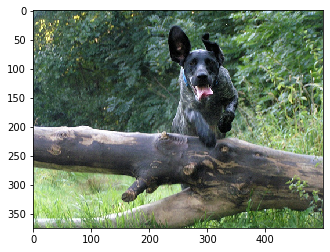

In [82]:
# check one sample
j = 9
plt.imshow(ds[j][0])
' '.join([itos[w.item()] for w in ds[j][1]])

In [90]:
# padding seqs
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx
        
    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)
        
        return imgs, targets

In [85]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [88]:
batch_size=32
num_workers=2
shuffle=True
pin_memory=True

In [89]:
dataset = FlickrDataset("flickr/", "one_desc.txt", transform=transform)

pad_idx = stoi["<PAD>"]

loader = DataLoader(
    dataset = dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=shuffle,
    pin_memory=pin_memory,
    collate_fn=MyCollate(pad_idx=pad_idx),
    drop_last=True
)

In [86]:
loader, dataset = get_loader(
    "flickr/", "one_desc.txt", transform=transform
)

In [87]:
for idx, (imgs, captions) in enumerate(loader):
    print(imgs.shape)
    print(captions.shape)
    print('_'*20)
    if idx == 4: break

torch.Size([32, 3, 224, 224])
torch.Size([24, 32])
____________________
torch.Size([32, 3, 224, 224])
torch.Size([23, 32])
____________________
torch.Size([32, 3, 224, 224])
torch.Size([21, 32])
____________________
torch.Size([32, 3, 224, 224])
torch.Size([28, 32])
____________________
torch.Size([32, 3, 224, 224])
torch.Size([23, 32])
____________________
